## Setup

In [1]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import cv2
import os
import matplotlib.pyplot as plt

from transformers import ViTModel, ViTImageProcessor

## Leitura das imagens

In [4]:
elefante_path = '../Data/zebra_elephants/train/elephants/'

zebra_path = '../Data/zebra_elephants/train/zebras/'

In [5]:
class CargaImagens:

    def __init__(self, elefante_path, zebra_path):
        self.elefante_path = elefante_path
        self.zebra_path = zebra_path 

        self.zebra_imgs_list = [img for img in os.listdir(zebra_path) if img.endswith('.jpeg')]
        self.elefante_imgs_list = [img for img in os.listdir(elefante_path) if img.endswith('.jpeg')]


    def __len__(self):
        return len(self.zebra_imgs_list) + len(self.elefante_imgs_list) 
    
    def len_elefantes(self):
        return len(self.elefante_imgs_list)
     
    def len_zebras(self):
         return len(self.zebra_imgs_list) 
    
    def img_read(self, idx, animal = None):
        if animal == "zebra":
            return cv2.imread(os.path.join(self.zebra_path, self.zebra_imgs_list[idx]))
        
        elif animal == 'elefante':
            return cv2.imread(os.path.join(self.elefante_path, self.elefante_imgs_list[idx]))
        else:
            raise 'Incluir o animal'
        
    def verifica_dimensoes(self):
        shapes = [self.img_read(i, animal).shape 
                  for animal in ['elefante', 'zebra'] 
                  for i in range(self.len_elefantes() if animal =='elefante' else self.len_zebras())]

        return set(shapes)
    
    def show_imgs(self, idx, animal):
        self.ax = plt.imshow(cv2.cvtColor(self.img_read(idx, animal),cv2.COLOR_BGR2RGB))
        plt.title(f'{animal} - indice: {idx}')
        


        
carga = CargaImagens(elefante_path, zebra_path)

In [6]:
#carga.verifica_dimensoes()

{(330, 330, 3)}

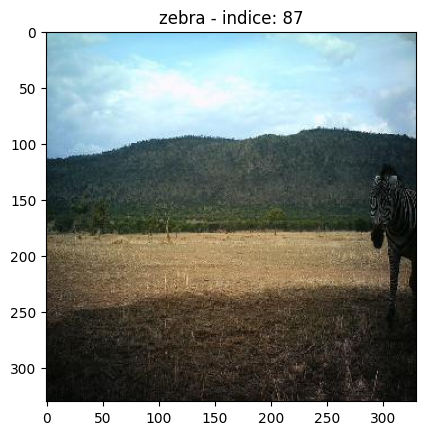

In [7]:
carga.show_imgs(87,"zebra")

In [2]:
dados_treino = torchvision.datasets.ImageFolder('../Data/zebra_elephants/train/', transform= torchvision.transforms.ToTensor())
dados_valid = torchvision.datasets.ImageFolder('../Data/zebra_elephants/valid/', transform= torchvision.transforms.ToTensor())
dados_teste = torchvision.datasets.ImageFolder('../Data/zebra_elephants/test/', transform= torchvision.transforms.ToTensor())

In [3]:
print(dados_treino, '\nClasses:', dados_treino.class_to_idx)
print('\n'+'='*50+'\n')
print(dados_valid, '\nClasses:', dados_valid.class_to_idx)
print('\n'+'='*50+'\n')
print(dados_teste)

Dataset ImageFolder
    Number of datapoints: 13529
    Root location: ../Data/zebra_elephants/train/
    StandardTransform
Transform: ToTensor() 
Classes: {'elephants': 0, 'zebras': 1}


Dataset ImageFolder
    Number of datapoints: 470
    Root location: ../Data/zebra_elephants/valid/
    StandardTransform
Transform: ToTensor() 
Classes: {'elephants': 0, 'zebras': 1}


Dataset ImageFolder
    Number of datapoints: 5999
    Root location: ../Data/zebra_elephants/test/
    StandardTransform
Transform: ToTensor()


## Classe do Modelo

### VIT


[Hugging Face - VIT documentation](https://huggingface.co/google/vit-base-patch16-224)

In [11]:
# Hiperparâmetros
EPOCHS = 5
BATCH_SIZE = 10
LEARNING_RATE = 1e-08
DEVICE = torch.device('cuda')

In [5]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')


In [12]:
dl_treino = data.DataLoader(dados_treino, batch_size = BATCH_SIZE, shuffle = True,  num_workers = 8)
dl_valid  = data.DataLoader(dados_valid, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)
dl_teste  = data.DataLoader(dados_teste, batch_size = BATCH_SIZE, shuffle = True, num_workers = 8)  

In [7]:
class ViTImageClassifier(nn.Module):

    def __init__(self, num_labels = 2):
        super(ViTImageClassifier, self).__init__()

        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values = pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])

        logits = self.classifier(output)
        loss = None

        if labels is not None:
            loss_function = nn.CrossEntropyLoss()
            loss = loss_function(logits.view(-1, self.num_labels), labels.view(-1))
            
        if loss is not None:
            return logits, loss.item()
        else:
            return logits, None



In [13]:
modelo = ViTImageClassifier()
modelo.cuda()

# Otimizador Adam
optimizer = torch.optim.Adam(modelo.parameters(), lr = LEARNING_RATE)

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

## Treinamento

In [17]:
%%time
for epoch in range(EPOCHS):        
    modelo.train()
    for step, (x, y) in enumerate(dl_treino):
        # Altera a matriz de entrada para uma lista com cada lote sendo um elemento
        x = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in x])
         
        # Envia para o device
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # batch x (imagem)
        b_x = Variable(x)  
        
        # batch y (target, ou seja, classe)
        b_y = Variable(y)   
        
        # Alimenta o modelo e extrai a previsão e o erro
        output, loss = modelo(b_x, None)
        
         # Calcula o erro final e aplica o backpropagation (otimização)
        if loss is not None: 
            loss = loss_func(output, b_y)   
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()
            
        # Print dos valores intermediários
        if step % 50 == 0:
            
            # Obtém o próximo lote para fins de validação
            valida = next(iter(dl_valid))
            valida_x = valida[0]
            
            # Reshape para obter matrizes de recursos conforme necessário
            valida_x = np.split(np.squeeze(np.array(valida_x)), BATCH_SIZE)
            
            for index, array in enumerate(valida_x):
                valida_x[index] = np.squeeze(array)
            
            # Gera o tensor com dados de validação em x
            valida_x = torch.tensor(np.stack(processor(valida_x)['pixel_values'], axis = 0))
            
            # Envia para o device
            valida_x = valida_x.to(DEVICE)
            valida_y = valida[1].to(DEVICE)
            
            # Obtém a saída do modelo (respectiva classe) 
            test_output, loss = modelo(valida_x, valida_y)
            
            # A saída final é o valor de maior probabilidade
            test_output = test_output.argmax(1)
            
            # Calcula a acurácia
            accuracy = (test_output == valida_y).sum().item() / BATCH_SIZE
            
            print('Epoch: ', epoch, '| Erro em Treino: %.4f' % loss, '| Acurácia em Validação: %.2f' % accuracy)
    

Epoch:  0 | Erro em Treino: 0.6913 | Acurácia em Validação: 0.50
Epoch:  0 | Erro em Treino: 0.7032 | Acurácia em Validação: 0.30
Epoch:  0 | Erro em Treino: 0.6888 | Acurácia em Validação: 0.50


KeyboardInterrupt: 

In [18]:
# Loop de treino
for epoch in range(EPOCHS):
    modelo.train()
    
    for step, (x, y) in enumerate(dl_treino):
        # Aplica o extrator de recursos 
        x = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in x])
        
        # Envia para o device
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # batch x (imagem)
        b_x = Variable(x)  
        
        # batch y (target, ou seja, classe)
        b_y = Variable(y)   
        
        # Alimenta o modelo e extrai a previsão e o erro
        output, loss = modelo(b_x, None)
        
        # Calcula o erro final e aplica o backpropagation (otimização)
        if loss is not None: 
            loss = loss_func(output, b_y)
            optimizer.zero_grad()           
            loss.backward()                 
            optimizer.step()
    
        # Print dos valores intermediários
        if step % 50 == 0:
            modelo.eval()
            with torch.no_grad():
                valida = next(iter(dl_valid))
                valida_x, valida_y = valida[0], valida[1]
                
                valida_x = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in valida_x])
                
                valida_x, valida_y = valida_x.to(DEVICE), valida_y.to(DEVICE)
                
                # Obtém a saída do modelo (respectiva classe) 
                test_output, loss = modelo(valida_x, valida_y)
                
                # A saída final é o valor de maior probabilidade
                test_output = test_output.argmax(1)
                
                # Calcula a acurácia
                accuracy = (test_output == valida_y).sum().item() / BATCH_SIZE
                
                print(f'Epoch: {epoch} | Erro em Treino: {loss:.4f} | Acurácia em Validação: {accuracy:.2f}')


Epoch: 0 | Erro em Treino: 0.6890 | Acurácia em Validação: 0.60
Epoch: 0 | Erro em Treino: 0.6975 | Acurácia em Validação: 0.40
Epoch: 0 | Erro em Treino: 0.6975 | Acurácia em Validação: 0.40


KeyboardInterrupt: 

## Avaliação e Deploy

In [95]:
# Salvando o modelo
torch.save(modelo, '../models/modelo_vit.pt')

In [96]:
modelo_vit = torch.load('../models/modelo_vit.pt')
modelo_vit.eval()

ViTImageClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [108]:
loader_nova_imagem = data.DataLoader(dados_valid, batch_size = 1, shuffle = True, num_workers = 4) 

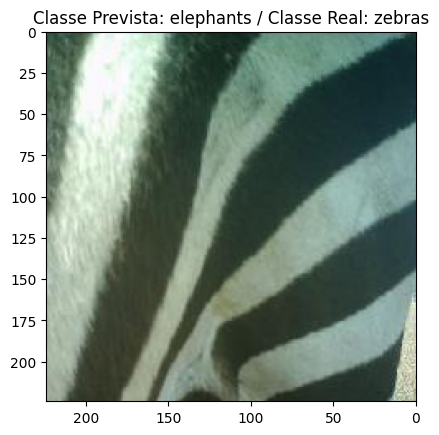

In [109]:
# Começamos desativando o track de gradientes, pois estamos em inferência e não em treino
with torch.no_grad():
    
    # Obtemos o input e a saída
    inputs, target = next(iter(loader_nova_imagem))
    originalInput = inputs[0].permute(1, 2, 0)
    
    # Reshape dos dados
    #inputs = inputs[0].permute(1, 2, 0)
    #
    ## Guarda o input original
    #originalInput = inputs
    #
    ## Reshape
    #for index, array in enumerate(inputs):
    #    inputs[index] = np.squeeze(array)
    #
    # Grava os inputs como tensor
    #inputs = torch.tensor(np.stack(processor(inputs)['pixel_values'], axis = 0))
    inputs = torch.stack([torch.tensor(processor(img, do_rescale=True)['pixel_values'][0]) for img in inputs])

    # Envia para o device
    inputs = inputs.to(DEVICE)
    target = target.to(DEVICE)
 
    # Gera a previsão do modelo
    prediction, loss = modelo_vit(inputs, target)
    
    # A previsão final é a classe de maior probabilidade
    predicted_class = np.argmax(prediction.cpu())
    
    # Valor previsto
    classe_prevista = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(predicted_class)]
    
    # Valor real
    classe_real = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(target)]
        
    # Mostra o resultado
    plt.imshow(originalInput)
    plt.xlim(224,0)
    plt.ylim(224,0)
    plt.title(f'Classe Prevista: {classe_prevista} / Classe Real: {classe_real}')
    plt.show()

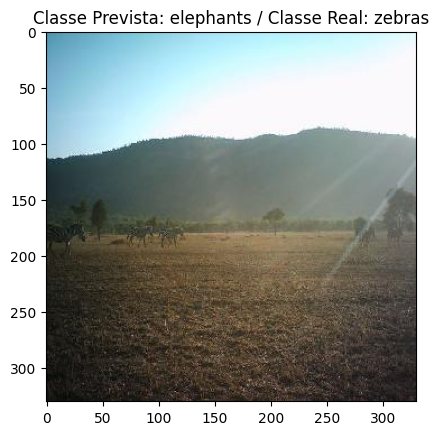

In [165]:
# Começamos desativando o track de gradientes, pois estamos em inferência e não em treino
with torch.no_grad():
    
    # Obtemos o input e a saída
    inputs, target = next(iter(loader_nova_imagem))
    
    # Guarda o input original para plotar
    original_input = inputs[0].permute(1, 2, 0).cpu().numpy()
    
    # Aplica o processador nas imagens de input
    processed_inputs = processor(images=inputs, return_tensors="pt")
    inputs = processed_inputs['pixel_values']
    
    # Envia para o device
    inputs = inputs.to(DEVICE)
    target = target.to(DEVICE)
 
    # Gera a previsão do modelo
    prediction, loss = modelo_vit(inputs, target)
    
    # A previsão final é a classe de maior probabilidade
    predicted_class = np.argmax(prediction.cpu())
    
    # Valor previsto
    classe_prevista = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(predicted_class)]
    
    # Valor real
    classe_real = list(dados_valid.class_to_idx.keys())[list(dados_valid.class_to_idx.values()).index(target.item())]
        
    # Mostra o resultado
    plt.imshow(original_input)
    plt.title(f'Classe Prevista: {classe_prevista} / Classe Real: {classe_real}')
    plt.show()
